In [3]:
import warnings
warnings.filterwarnings('ignore')


In [24]:
import pandas as pd
import lightning.pytorch as pl

import numpy as np
import pandas as pd
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import CrossEntropy

import shap

In [25]:
df

0          227368
1          626053
2          608569
3          608569
4          608569
            ...  
7005210    627200
7005211    628998
7005212    488527
7005213    488527
7005214    488527
Name: user, Length: 7005215, dtype: int64

In [26]:
df = pd.read_csv("custom_df.csv")
df.rename(columns={"clk": "click"},inplace=True)
df['age_level'] = df['age_level'].astype(str)

In [27]:
brand_mapping = {
    98931: 'nike',
    247789: 'adidas',
    353787: 'puma',
    342760: 'reebok',
    82527: 'under armour',
    234846: 'new balance',
    143597: 'asics',
    146115: 'converse',
    454237: 'vans',
    95766: 'fila'
}
df['brand'] = df['brand'].replace(brand_mapping)

In [28]:
# Wie oft wird welche Brand durchschnittlich geklickt?
df.groupby('brand')['click'].mean()

brand
3.0             0.036204
21.0            0.039232
38.0            0.054968
39.0            0.038718
46.0            0.039769
                  ...   
nike            0.024489
puma            0.043726
reebok          0.046499
under armour    0.070515
vans            0.054479
Name: click, Length: 2732, dtype: float64

<Axes: >

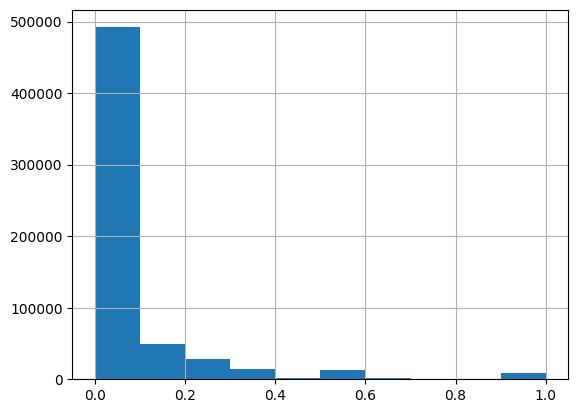

In [29]:
# Wie oft hat jeder User durchschnittlich geklickt?
df.groupby('user')['click'].mean().hist(bins=10)

<Axes: >

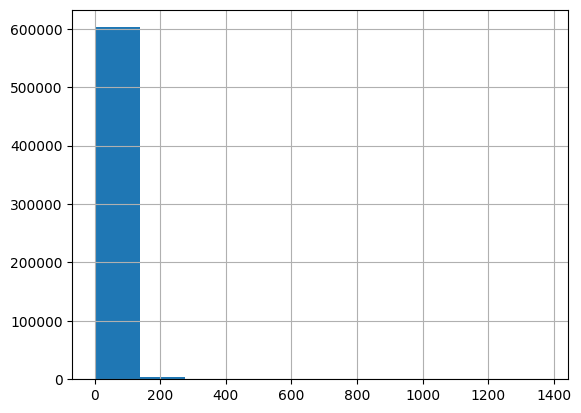

In [30]:
df['user'].value_counts().hist(bins=10)

- Viele Zeitschritte zwischendrin fehlen
- Wenn wir nur User mit 11 konsekutiven timesteps drin lassen, fliegen fast alle raus. Unrealistisches Szenario.
- Setze allow_missing_timesteps = True in TimeSeriesDataset


In [31]:
len(df)

7005215

In [34]:
# Sonst akzeptiert pytorch_forecasting es nicht als kategorische Zielvariable
df['click'] = df['click'].astype(str)
df['brand'] = df['brand'].astype(str)

In [35]:
training = TimeSeriesDataSet(
    df[lambda x: x.time_idx <= 10],
    time_idx="time_idx",
    target="click",
    group_ids=["user"],
    
    min_encoder_length=10,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=10,
    min_prediction_length=1,
    max_prediction_length=1,
    
    static_categoricals=["age_level"],
    time_varying_known_categoricals=["brand"],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_categoricals=["click"],

    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    
    allow_missing_timesteps=True
)

**-> User Warning zeigt uns hier, dass 7647 Einträge entfernt werden würden, weil Sie sich nicht mit einer Länge von 10 encodieren lassen. Reduziere min_length auf 1**

In [36]:
training = TimeSeriesDataSet(
    df[lambda x: x.time_idx <= 10],
    time_idx="time_idx",
    target="click",
    group_ids=["user"],
    
    min_encoder_length=1,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=10,
    min_prediction_length=1,
    max_prediction_length=1,
    
    static_categoricals=["age_level"],
    time_varying_known_categoricals=["brand"],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_categoricals=["click"],

    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    
    allow_missing_timesteps=True
)

In [37]:
user_counts = df['user'].value_counts()

users_with_one_occurrence = user_counts[user_counts == 1]

num_users_with_one_occurrence = len(users_with_one_occurrence)

print(num_users_with_one_occurrence)


114104


**Es gibt also 3455 die nur 1 timestep haben, hier können wir gar nicht encodieren. pytorch_forecasting entfernt uns diese laut Warning direkt**

### Trainiere TFT Modell

In [38]:
# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, df, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 16  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size)

In [39]:
tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=8,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    
    
    #TODO: Loss ändern
    loss=CrossEntropy(),
    optimizer="Ranger"
    # reduce learning rate if no improvement in validation loss after x epochs
    # reduce_on_plateau_patience=1000,
)

In [40]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    accelerator="cpu",
    gradient_clip_val=0.1,
    max_epochs=1
)

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [41]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | CrossEntropy                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 21.9 K
3  | prescalers                         | ModuleDict                      | 48    
4  | static_variable_selection          | VariableSelectionNetwork        | 400   
5  | encoder_variable_selection         | VariableSelectionNetwork        | 904   
6  | decoder_variable_selection         | VariableSelectionNetwork        | 814   
7  | static_context_variable_selection  | GatedResidualNetwork            | 304   
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 304   
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 304 

Epoch 0:   2%| | 4614/304685 [02:20<2:32:15, 32.85it/s, v_num=1349, train_loss_s

### Inferenz 

- wähle user=953596, da er 10 konsekutive timesteps hat
- schreibe wrapper für tft in sklearn Schreibweise, damit shap library ihn annimmt.

In [42]:
df['user'].value_counts().head(1)

KeyboardInterrupt: 

In [24]:
df_test = df[df['user']==953596]

In [25]:
df_test

,user,age_level,brand,click,time_stamp,time_idx
15661,953596,5,nike,1,2017-05-06 03:44:20,0
15662,953596,5,nike,0,2017-05-06 03:44:20,1
15663,953596,5,nike,0,2017-05-07 11:37:46,2
15664,953596,5,nike,0,2017-05-07 11:37:46,3
15665,953596,5,nike,0,2017-05-07 11:37:46,4
15666,953596,5,nike,0,2017-05-08 12:40:24,5
15667,953596,5,nike,0,2017-05-08 12:40:24,6
15668,953596,5,nike,0,2017-05-08 12:40:24,7
15669,953596,5,nike,0,2017-05-13 05:41:13,8
15670,953596,5,nike,0,2017-05-13 05:41:13,9


In [26]:
#Hilfsmethode um Code in Wrapper übersichtlich zu halten
def get_tsds(df):
    return TimeSeriesDataSet(
    df[lambda x: x.time_idx <= 10],
    time_idx="time_idx",
    target="click",
    group_ids=["user"],
    
    min_encoder_length=0,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=10,
    min_prediction_length=1,
    max_prediction_length=1,
    
    static_categoricals=["age_level"],
    time_varying_known_categoricals=["brand"],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_categoricals=["click"],

    add_relative_time_idx=True,
    add_target_scales=False,
    add_encoder_length=True,
    
    allow_missing_timesteps=True,
        
        
        
    # WICHTIG!!!    
    predict_mode=True
)

In [61]:
class Custom_TFT():
    
    def __init__(self,tft,df):
        self.tft = tft
        self.columns = df.columns
        self.dtypes = df.dtypes
    
    def fit(self):
        pass
    
    
    def predict(self, X_arr) -> np.ndarray:
        
        #print(type(df))
        #print(df)
        df = pd.DataFrame(X_arr,columns=self.columns).astype(self.dtypes)
        print("***NEW CALL**")
        print(df)
        tsds = get_tsds(df)
        
        
        
        preds = tft.predict(tsds, mode="raw", return_x=False).prediction.flatten().numpy()
        #TODO: überführe preds in ein numpy array
        #return preds
        return np.array([0,0,0,0,0,0,0,0,0,0,0])
    
    def predict_proba(self, df) -> np.ndarray:
        #TODO: checke ob probabilities übereinstimmen mit prediction! -> passt
        tsds = get_tsds(df)
        probabilities = Softmax(dim=2)(tft.predict(tsds, mode="raw", return_x=False).prediction).flatten().numpy()
        return probabilities
    


In [62]:
my_tft = Custom_TFT(tft.predict,df_test)


In [63]:
explainer = shap.KernelExplainer(my_tft.predict,df_test)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


***NEW CALL**
      user age_level brand click           time_stamp  time_idx
0   953596         5  nike     1  2017-05-06 03:44:20         0
1   953596         5  nike     0  2017-05-06 03:44:20         1
2   953596         5  nike     0  2017-05-07 11:37:46         2
3   953596         5  nike     0  2017-05-07 11:37:46         3
4   953596         5  nike     0  2017-05-07 11:37:46         4
5   953596         5  nike     0  2017-05-08 12:40:24         5
6   953596         5  nike     0  2017-05-08 12:40:24         6
7   953596         5  nike     0  2017-05-08 12:40:24         7
8   953596         5  nike     0  2017-05-13 05:41:13         8
9   953596         5  nike     0  2017-05-13 05:41:13         9
10  953596         5  nike     0  2017-05-13 05:41:13        10


The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.


**Erklärungen**
- shap.KernelExplainer ändert uns den Input von einem pd.Dataframe automatisch auf ein np.array was dann bei predict() ankommt.
- TimeSeriesDataset kann nur aus pd.Dataframe erzeugt werden.
- unschöner workaround: erzeuge aus dem np.array wieder einen pd.Dataframe indem die columns und dtypes abgespeichert werden  

  
- tft.predict() liefert 2 probabilities zurück, da es für den letzten timestep predicted und wir 2 Klassen haben.
- shap erwartet aber für jede Zeile einen Wert zurück.

- workaround um einfach zu testen, wie shap weiter funktioniert -> gebe ein np.array der selben Länge zurück

- explainer.shap_values(df_test) erzeugt neuen Dataframe der viel länger ist, da er eine Zeile immer als ein Sample sieht und neue erzeugt. Er ändert dabei auch time_stamp und time_idx. Unsere predict Methode kann dann auf einen solchen DF nicht mehr angewandt werden. 


**Hauptproblem**: Mismatch, dass im TimeSeriesDataset ein sample 10 Reihen zum encoden und 1 Reihe zum predicten bedeutet und bei Shap bedeutet ein sample eine Reihe.


In [64]:
explainer.shap_values(df_test)


  0%|                                                    | 0/11 [00:00<?, ?it/s]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


***NEW CALL**
     user age_level brand click           time_stamp  time_idx
0  953596         5  nike     1  2017-05-06 03:44:20         0
***NEW CALL**
      user age_level brand click           time_stamp  time_idx
0   953596         5  nike     1  2017-05-06 03:44:20         0
1   953596         5  nike     1  2017-05-06 03:44:20         1
2   953596         5  nike     1  2017-05-07 11:37:46         2
3   953596         5  nike     1  2017-05-07 11:37:46         3
4   953596         5  nike     1  2017-05-07 11:37:46         4
..     ...       ...   ...   ...                  ...       ...
61  953596         5  nike     1  2017-05-06 03:44:20         6
62  953596         5  nike     1  2017-05-06 03:44:20         7
63  953596         5  nike     1  2017-05-06 03:44:20         8
64  953596         5  nike     1  2017-05-06 03:44:20         9
65  953596         5  nike     1  2017-05-06 03:44:20        10

[66 rows x 6 columns]


The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  0%|                                                    | 0/11 [00:00<?, ?it/s]


ValueError: cannot reshape array of size 11 into shape (66,1)